# Debugging the Pipline

in this notebook we want to get our pipeline up and running and test the key components




In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.test import do_test
from src.train import do_train
from src.predict import predict_image_in_acdc



## Convert ACDC data to COCO format

check coco json file:

In [2]:
with open("/vol/volume/data/cellpose/train/cell_acdc_coco_ds.json") as file:
    train_dict = json.load(file)

In [3]:
print(list(train_dict.keys()),"\n")
print(json.dumps(train_dict["info"], indent=4))
if False:
    print("\ncategories:\n",json.dumps(train_dict["categories"], indent=4))
    print("\nimages:\n",json.dumps(train_dict["images"][0], indent=4))
    print("\nannotations:\n",json.dumps(train_dict["annotations"][0], indent=4))


['info', 'licenses', 'categories', 'images', 'annotations'] 

{
    "description": "Cell ACDC data in COCO format",
    "url": "",
    "version": "0.1.0",
    "year": 2022,
    "contributor": "Florian Bridges",
    "date_created": "2022-10-16 09:22:07.477724"
}


Show some raw images:

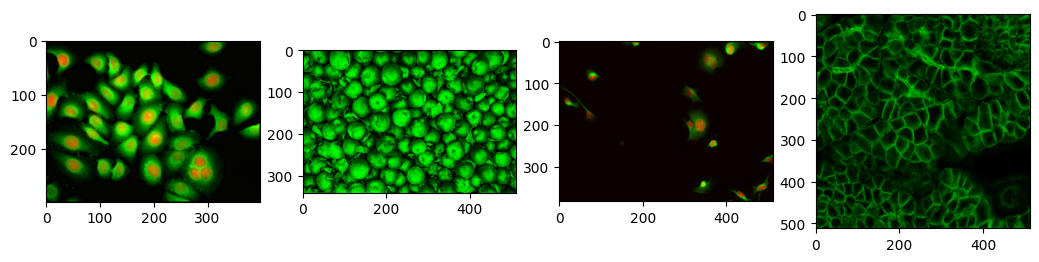

['192HFVT.png', '510HTVF.png', '64HTVT.png', '316HTVF.png']


In [3]:
#rd.seed(1337)
images_meta_data = rd.sample(train_dict["images"], 4)
imgs = [mpimg.imread("/vol/volume/data/cellpose/train/images/" + image["file_name"]) for image in images_meta_data]
show_image(imgs)
print([image["file_name"] for image in images_meta_data])


## Detectron2

### Register Datasets

In [5]:
register_datasets()

registering acdc_large dataset
registering acdc_small dataset
registering cellpose dataset


### Inspect Groundtruth


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



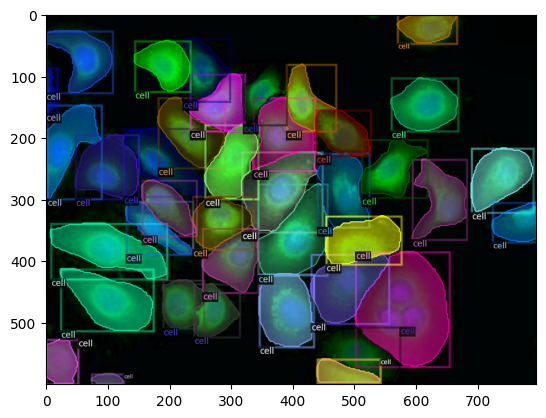

396


In [6]:
cfg = get_cfg()
cfg.DATASETS.TRAIN = (get_dataset_name(CELLPOSE,TRAIN),)

in_image_id = images_meta_data[0]["id"]
in_image_json = list(filter(lambda image: image["image_id"] == in_image_id, DatasetCatalog.get(get_dataset_name(CELLPOSE,TRAIN)) ))[0]
in_image = cv2.imread(in_image_json["file_name"]) #imgs[0]
visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
out = visualizer.draw_dataset_dict(in_image_json)
out_image = out.get_image()[:, :, ::-1]
show_image(out_image)
print(in_image_id)


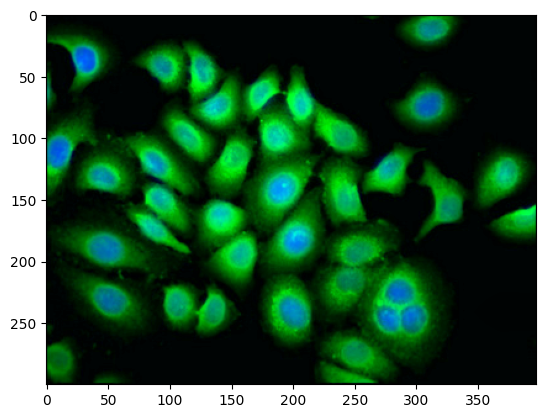

In [7]:
show_image(in_image)

## Train a Model

### Train Model with single Datapoint

define cfg and save as yaml file

In [7]:
'''cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (SINGLE_POINT_DATASET,)
cfg.DATASETS.TEST = (SINGLE_POINT_DATASET,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "./output/..."'''

#with open("./src/pipeline_configs/single_datapoint.yaml","w") as file:
#    file.write(cfg.dump())

'cfg = get_cfg()\ncfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))\ncfg.DATASETS.TRAIN = (SINGLE_POINT_DATASET,)\ncfg.DATASETS.TEST = (SINGLE_POINT_DATASET,)\ncfg.DATALOADER.NUM_WORKERS = 2\ncfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo\ncfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people\ncfg.SOLVER.BASE_LR = 0.00025  # pick a good LR\ncfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset\ncfg.SOLVER.STEPS = []        # do not decay learning rate\ncfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)\ncfg.MODEL.ROI_HEADS.NUM_CLASSES = 1\ncfg.OUTPUT_DIR = "./output/..."'

Train model from terminal

In [8]:
#!python src/pipeline_runner.py -f ./src/pipeline_configs/single_datapoint.yaml

In [9]:
'''import os
from detectron2.engine import DefaultPredictor

logger = setup_logger(output="./log/main.log")
logger.setLevel(0)
cfg = get_cfg()
cfg.merge_from_file("./src/pipeline_configs/single_datapoint.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(SINGLE_POINT_DATASET)[0]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(out.get_image()[:, :, ::-1])'''

AssertionError: Checkpoint ./output/model_final.pth not found!

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (TRAIN_DATASET_FULL,)
cfg.DATASETS.TEST = (TEST_DATASET_FULL,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "./output/src/pipeline_configs/more_steps_config"

#with open("./src/pipeline_configs/default_config.yaml","w") as file:
#    file.write(cfg.dump())


In [11]:
#!python src/pipeline_runner.py -f ./src/pipeline_configs/default_config.yaml

WARNING [10/27 09:23:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



/home/ubuntu/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


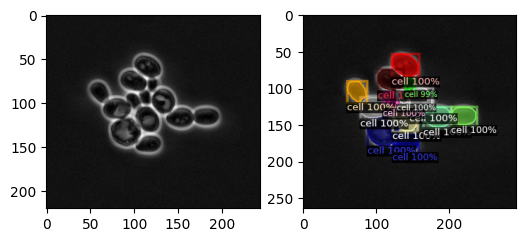

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image

im = cv2.imread(DatasetCatalog.get(TEST_DATASET_FULL)[100]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

In [13]:
evaluator = COCOEvaluator(TEST_DATASET_FULL, output_dir=cfg.OUTPUT_DIR)
data_loader = build_detection_test_loader(cfg, TEST_DATASET_FULL)
evaluator = COCOEvaluator(TEST_DATASET_FULL, output_dir=cfg.OUTPUT_DIR)
results_i = inference_on_dataset(predictor.model, data_loader, evaluator)
print(results_i)

WARNING [10/27 09:23:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.851
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.567
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.879
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | m

In [14]:
results_i

OrderedDict([('bbox',
              {'AP': 85.08512568459093,
               'AP50': 97.02390128954062,
               'AP75': 92.98328962445083,
               'APs': 85.18117940372954,
               'APm': nan,
               'APl': nan}),
             ('segm',
              {'AP': 85.38577880508501,
               'AP50': 97.0214542133414,
               'AP75': 92.98142684947993,
               'APs': 85.38577880508501,
               'APm': nan,
               'APl': nan})])

In [15]:
%%capture
result_array = []
for image_id in [image["image_id"] for image in DatasetCatalog.get(TEST_DATASET_FULL)]:
    result = evaluator.evaluate(image_id)
    result_array.append(result)
print(result_array)
aps = [result['segm']['AP'] for result in result_array]
worse_aps_ids = [aps.index(ap) for ap in aps if ap < 70]
print(worse_aps_ids)

WARNING [10/27 09:23:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [16]:
min(aps)

72.77227722772277

## Some of the worse performing Images

In [17]:
worse_aps_ids = [aps.index(ap) for ap in aps if ap < 75]
print(worse_aps_ids)

[18, 163, 163, 215, 224]


WARNING [10/27 09:26:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



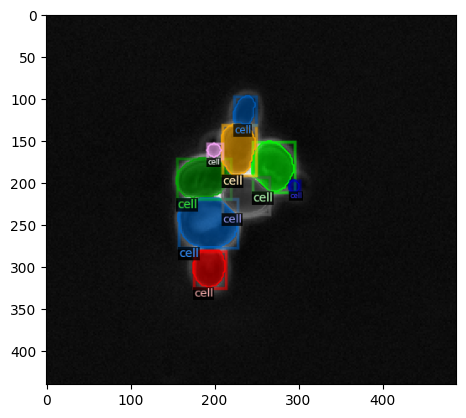

In [37]:
def plot_ground_truth(image_json):

    in_image = cv2.imread(image_json["file_name"])
    visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(TEST_DATASET_FULL), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    out_image = out.get_image()[:, :, ::-1]
    #show_image([in_image,out_image])
    show_image(out_image)

worse_id = 4
image_json = DatasetCatalog.get(TEST_DATASET_FULL)[worse_aps_ids[worse_id]]
plot_ground_truth(image_json)

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(TEST_DATASET_FULL)[worse_aps_ids[worse_id]]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

KeyError: "Dataset 'cell_acdc_test' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, cell_acdc_train, cell_acdc_train_single_sample, cell_acdc_validation_slim"

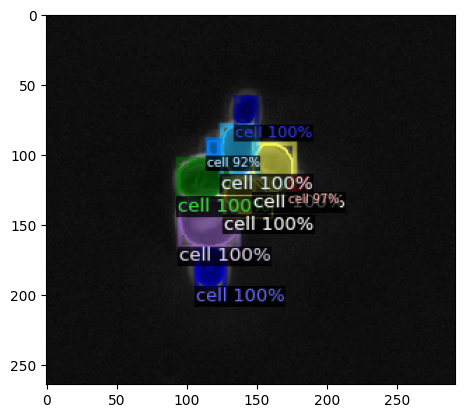

In [39]:
show_image(out.get_image()[:, :, ::-1])

## Back to ACDC format

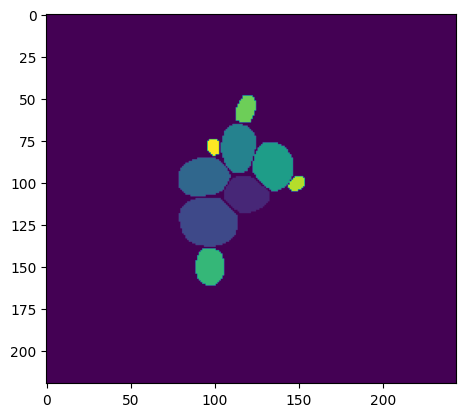

In [41]:
show_image(predict_image_in_acdc(cfg,im),normalize=False)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



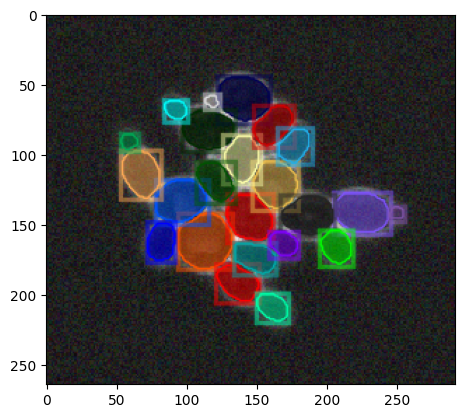

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(TEST_DATASET_FULL)[164]["file_name"])
im = im + 40 * np.random.rand(im.shape[0],im.shape[1],im.shape[2])

outputs = predictor(im)
predictions = outputs["instances"].to("cpu")
predictions.remove("scores")
predictions.remove("pred_classes")
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("cell_acdc_validation_slim"), scale=1.2)
out = v.draw_instance_predictions(predictions)
show_image(out.get_image()[:, :, ::-1], normalize=False)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



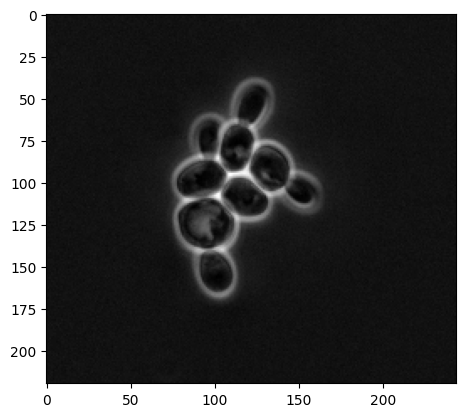

In [19]:
im = cv2.imread(DatasetCatalog.get("cell_acdc_validation_slim")[0]["file_name"])
show_image(im)

In [23]:
res = outputs["instances"].to("cpu").remove("scores")

In [31]:
outputs["instances"].to("cpu").scores

tensor([0.9990, 0.9988, 0.9987, 0.9984, 0.9983, 0.9971, 0.9920, 0.9914, 0.9909])

In [32]:
object_methods = [method_name for method_name in dir(outputs["instances"].to("cpu"))
                  if callable(getattr(outputs["instances"].to("cpu"), method_name))]

In [34]:
res = outputs["instances"].to("cpu")

In [38]:
res.remove("pred_classes")

In [37]:
res

Instances(num_instances=9, image_height=220, image_width=244, fields=[pred_boxes: Boxes(tensor([[103.9269,  65.4610, 123.8585,  94.9157],
        [ 78.0054, 110.6207, 112.4853, 139.8598],
        [ 90.7814, 142.7114, 111.8759, 166.6313],
        [120.7293,  77.9610, 145.7985, 106.6109],
        [104.1269,  97.1649, 132.1077, 121.9977],
        [ 77.0568,  86.5501, 107.4641, 110.4201],
        [143.1989,  97.1204, 159.6683, 113.7280],
        [113.3611,  42.0996, 132.5395,  65.4314],
        [ 90.3834,  63.6644, 104.1372,  84.9379]])), pred_classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, Fa

In [8]:
import numpy as np